Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B, tau_bg]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 3 seconds.


Estimated background: B = 4918.35, tau_bg = 1006.46 ms


Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, tau, t_shift1, t_shift2, t_shift3]


Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 11 seconds.
There were 75 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7965, but should be close to 0.95. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8003, but should be close to 0.95. Try to increase the number of tuning steps.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7812, but should be close to 0.95. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8458, but should be close to 0.95. Try to increase the number of tuning steps.


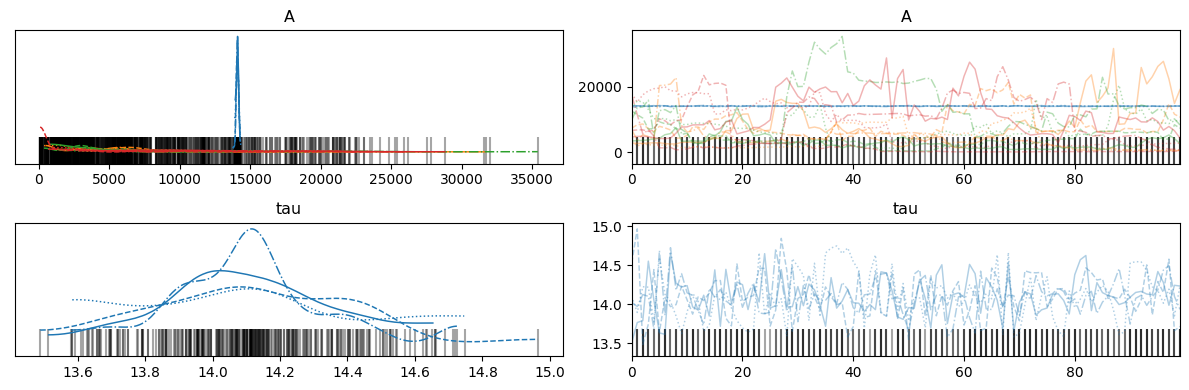

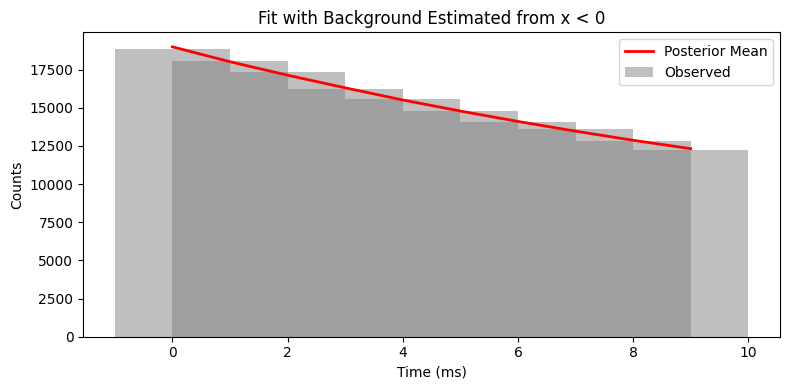

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import aesara.tensor as at
import arviz as az

# --- Load data and rebin ---
df = pd.read_csv("hist_33Na.csv")
df = df[(df["xVal"] >= -100) & (df["xVal"] <= 10)]
df["bin"] = (df["xVal"] // 1) * 1
df_rebinned = df.groupby("bin").agg({"yVal": "sum"}).reset_index()
x = df_rebinned["bin"].values
y = df_rebinned["yVal"].values

# Split into background (x < 0) and decay (x >= 0)
x_bg = x[x < 0].astype(float)
y_bg = y[x < 0].astype(int)
x_decay = x[x >= 0].astype(float)
y_decay = y[x >= 0].astype(int)

# --- Step 1: Fit exponential background model ---
with pm.Model() as bg_model:
    B = pm.HalfNormal("B", sigma=1e5)
    tau_bg = pm.HalfNormal("tau_bg", sigma=50)
    mu_bg = B * at.exp(-x_bg / tau_bg)
    y_bg_obs = pm.Poisson("y_bg_obs", mu=mu_bg, observed=y_bg)
    trace_bg = pm.sample(draws=2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Extract posterior means for fixed background
B_fit = trace_bg.posterior["B"].mean().item()
tau_bg_fit = trace_bg.posterior["tau_bg"].mean().item()
print(f"Estimated background: B = {B_fit:.2f}, tau_bg = {tau_bg_fit:.2f} ms")

# --- Define delayed exponential function ---
def delayed_exp(t, A, tau, t_shift):
    return A * at.exp(-(t - t_shift) / tau) * at.switch(t >= t_shift, 1.0, 0.0)

# --- Step 2: Main model for x >= 0 using fixed background ---
with pm.Model() as model:
    A = pm.HalfNormal("A", sigma=1e4, shape=4)
    tau = pm.HalfNormal("tau", sigma=20)

    # Fixed background from exponential fit
    background = B_fit * at.exp(-x_decay / tau_bg_fit)

    # Known daughter half-lives
    tau_d1 = 90.2 / np.log(2)
    tau_d2 = 80.4 / np.log(2)
    tau_d3 = 270 / np.log(2)

    t_shift1 = pm.HalfNormal("t_shift1", sigma=10)
    t_shift2 = pm.HalfNormal("t_shift2", sigma=10)
    t_shift3 = pm.HalfNormal("t_shift3", sigma=10)

    raw_mu = (
        delayed_exp(x_decay, A[0], tau, 0.0) +
        delayed_exp(x_decay, A[1], tau_d1, t_shift1) +
        delayed_exp(x_decay, A[2], tau_d2, t_shift2) +
        delayed_exp(x_decay, A[3], tau_d3, t_shift3) +
        background
    )

    mu = at.clip(raw_mu, 1e-3, np.inf)
    

    y_obs = pm.Poisson("y_obs", mu=mu, observed=y_decay)
    step = pm.NUTS(target_accept=0.95, max_treedepth=15)
    trace = pm.sample(draws=100, tune=100, step=step, chains=4, cores=4)

# --- Posterior plots ---
az.plot_trace(trace, var_names=["A", "tau"])
plt.tight_layout()
plt.show()

# --- Posterior predictive check ---
with model:
    ppc = pm.sample_posterior_predictive(trace, return_inferencedata=True)

y_pred_mean = ppc.posterior_predictive["y_obs"].mean(dim=("chain", "draw")).values

# --- Plot results ---
plt.figure(figsize=(8, 4))
plt.bar(x_decay, y_decay, width=2, alpha=0.5, label="Observed", color='gray')
plt.plot(x_decay, y_pred_mean, color="red", lw=2, label="Posterior Mean")
plt.xlabel("Time (ms)")
plt.ylabel("Counts")
plt.legend()
plt.title("Fit with Background Estimated from x < 0")
plt.tight_layout()
plt.show()


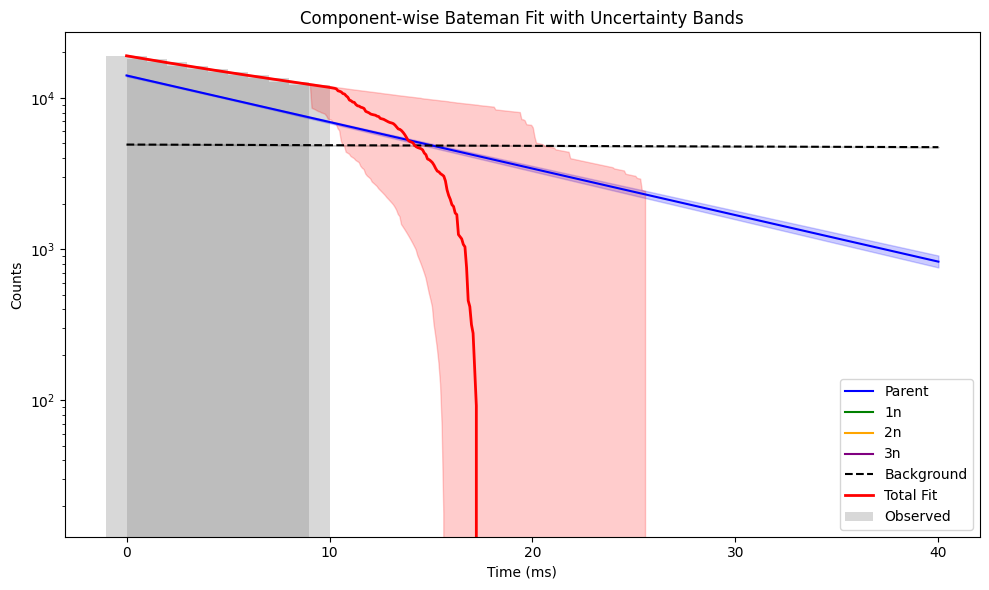

In [33]:
# Sample posterior draws for uncertainty bands
posterior_samples = trace.posterior.stack(samples=("chain", "draw"))

# Draw 200 random posterior samples
n_draws = 200
draw_idx = np.random.choice(posterior_samples.samples.size, size=n_draws, replace=False)

t_fine = np.linspace(0, 40, 500)
fit_total = np.zeros((n_draws, len(t_fine)))
fit_terms = {f"term{i}": np.zeros((n_draws, len(t_fine))) for i in range(4)}
fit_bg = np.zeros((n_draws, len(t_fine)))

for i, idx in enumerate(draw_idx):
    A_sample = posterior_samples["A"].isel(samples=idx).values
    tau_0_s = posterior_samples["tau"].isel(samples=idx).values.item()
    t1 = posterior_samples["t_shift1"].isel(samples=idx).values.item()
    t2 = posterior_samples["t_shift2"].isel(samples=idx).values.item()
    t3 = posterior_samples["t_shift3"].isel(samples=idx).values.item()

    BRs = A_sample[1:] / np.sum(A_sample[1:])
    A0 = A_sample[0]

    # Components
    term0 = A0 * np.exp(-t_fine / tau_0_s)
    term1 = BRs[0] * A0 * (np.exp(-t_fine / tau_0_s) - np.exp(-(t_fine - t1) / tau_d1)) * (t_fine > t1)
    term2 = BRs[1] * A0 * (np.exp(-t_fine / tau_0_s) - np.exp(-(t_fine - t2) / tau_d2)) * (t_fine > t2)
    term3 = BRs[2] * A0 * (np.exp(-t_fine / tau_0_s) - np.exp(-(t_fine - t3) / tau_d3)) * (t_fine > t3)
    bkg = B_fit * np.exp(-t_fine / tau_bg_fit)

    fit_terms["term0"][i] = term0
    fit_terms["term1"][i] = term1
    fit_terms["term2"][i] = term2
    fit_terms["term3"][i] = term3
    fit_bg[i] = bkg
    fit_total[i] = term0 + term1 + term2 + term3 + bkg

# --- Plot with uncertainty bands ---
plt.figure(figsize=(10, 6))
plt.bar(x_decay, y_decay, width=2, alpha=0.3, label="Observed", color="gray")

colors = ['blue', 'green', 'orange', 'purple']
labels = ['Parent', '1n', '2n', '3n']

for i, key in enumerate(["term0", "term1", "term2", "term3"]):
    median = np.median(fit_terms[key], axis=0)
    lower = np.percentile(fit_terms[key], 2.5, axis=0)
    upper = np.percentile(fit_terms[key], 97.5, axis=0)
    plt.plot(t_fine, median, label=labels[i], color=colors[i])
    plt.fill_between(t_fine, lower, upper, alpha=0.2, color=colors[i])

# Background
bg_median = np.median(fit_bg, axis=0)
bg_lower = np.percentile(fit_bg, 2.5, axis=0)
bg_upper = np.percentile(fit_bg, 97.5, axis=0)
plt.plot(t_fine, bg_median, label="Background", color="black", linestyle="--")
plt.fill_between(t_fine, bg_lower, bg_upper, alpha=0.2, color="black")

# Total
total_median = np.median(fit_total, axis=0)
total_lower = np.percentile(fit_total, 2.5, axis=0)
total_upper = np.percentile(fit_total, 97.5, axis=0)
plt.plot(t_fine, total_median, color="red", lw=2, label="Total Fit")
plt.fill_between(t_fine, total_lower, total_upper, alpha=0.2, color="red")

plt.xlabel("Time (ms)")
plt.ylabel("Counts")
plt.title("Component-wise Bateman Fit with Uncertainty Bands")
plt.legend()
plt.yscale("log")
plt.tight_layout()
plt.show()


In [35]:
print("A_mean:", A_mean)
print("t_shift1:", t_shift1_mean)
print("t_shift2:", t_shift2_mean)
print("t_shift3:", t_shift3_mean)


A_mean: [21544.73525211  2801.24677433  2225.86195456  2523.74311973]
t_shift1: 13.032787703114888
t_shift2: 8.933534879827668
t_shift3: 10.831141428199812


In [28]:
az.summary(trace, var_names=["A", "tau","t_shift1","t_shift2","t_shift3"], round_to=2)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A[0],27204.34,147.73,26905.75,27486.82,7.91,5.60,340.49,271.65,1.00
A[1],7343.98,6560.62,241.08,20929.76,1059.27,754.79,11.45,15.11,1.34
A[2],9018.69,6274.14,492.96,20126.70,1701.31,1229.79,10.22,56.52,1.37
A[3],5825.59,6387.06,97.48,20586.85,2134.15,1561.13,6.67,33.82,1.70
tau,14.11,0.25,13.64,14.57,0.01,0.01,355.18,189.75,1.02
t_shift1,13.25,4.89,8.02,22.32,0.57,0.40,66.05,73.63,1.03
t_shift2,14.57,5.30,8.00,23.89,1.17,0.84,16.21,44.54,1.21
t_shift3,13.59,4.50,8.03,21.60,0.48,0.34,83.42,186.48,1.04


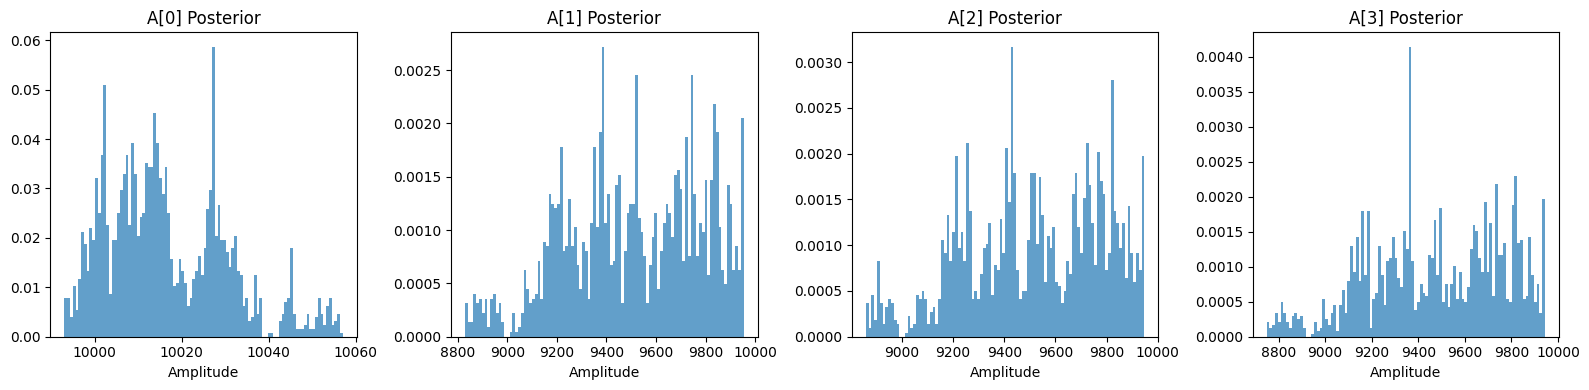

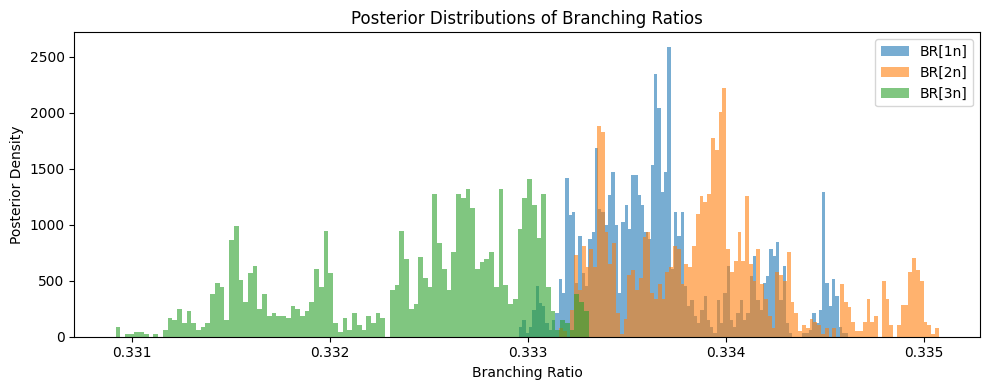

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Stack A samples: shape (4, n_samples)
A_samples = trace.posterior["A"].stack(samples=("chain", "draw")).values

# Compute branching ratios over samples (exclude A[0] = parent)
A_daughters = A_samples[1:4]
A_sum = A_daughters.sum(axis=0)
br_samples = A_daughters / A_sum

# Plot A[i]
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axes[i].hist(A_samples[i], bins=100, density=True, alpha=0.7)
    axes[i].set_title(f"A[{i}] Posterior")
    axes[i].set_xlabel("Amplitude")
plt.tight_layout()
plt.show()

# Plot BR[i]
labels = ["BR[1n]", "BR[2n]", "BR[3n]"]
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.hist(br_samples[i], bins=100, alpha=0.6, label=labels[i], density=True)
plt.xlabel("Branching Ratio")
plt.ylabel("Posterior Density")
plt.title("Posterior Distributions of Branching Ratios")
plt.legend()
plt.tight_layout()
plt.show()


IndexError: index 3 is out of bounds for axis 0 with size 3

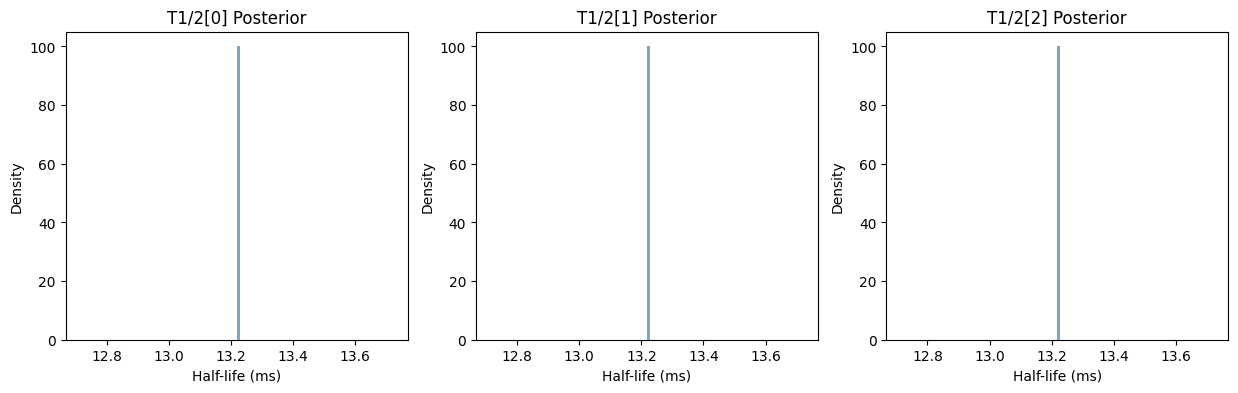

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Stack all posterior samples
A_samples = trace.posterior["A"].stack(samples=("chain", "draw")).values
tau_samples = trace.posterior["tau"].stack(samples=("chain", "draw")).values
t_half_samples = tau_samples * np.log(2)

# --- Plot each T1/2 separately ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i in range(4):
    axes[i].hist(t_half_samples[i], bins=100, density=True, alpha=0.7, color='steelblue')
    axes[i].set_title(f"T1/2[{i}] Posterior")
    axes[i].set_xlabel("Half-life (ms)")
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.show()

# --- Plot each Amplitude separately ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i in range(4):
    axes[i].hist(A_samples[i], bins=100, density=True, alpha=0.7, color='darkorange')
    axes[i].set_title(f"A[{i}] Posterior")
    axes[i].set_xlabel("Amplitude")
    axes[i].set_ylabel("Density")
plt.tight_layout()
plt.show()
